In [1]:
import gym
import atari_py

import numpy as np
import matplotlib.pyplot as plt
import torch


def screen2filter(screen, food_kernel, show=True, show_raw=False):
    '''
    It performs the convolution of the matrix screen by means of 
    the food_kernel matrix. Then it returns the matrix which has
    value equal to 1 where the convolution produced its maxima 
    (i.e., the foods' geometrical centers), and 0 elsewhere.
    '''
    screen_tens = torch.from_numpy(screen).type(torch.float)
    screen_tens = screen_tens.unsqueeze(0).unsqueeze(0)

    screen_tens = torch.from_numpy(screen).type(torch.float)
    screen_tens = screen_tens.unsqueeze(0).unsqueeze(0)

    kernel = torch.from_numpy(food_kernel).type(torch.float)
    kernel = kernel.unsqueeze(0).unsqueeze(0)

    filter_tens = torch.nn.functional.conv2d(screen_tens, kernel, padding=(1, 2))
    filter_raw = filter_tens.data.numpy()[0, 0, :, :]
    filter = (filter_raw == filter_raw.max()).astype(int)

    return filter


def filter2coords(filter):
    '''
    Takes as input the filter and returns the array with all the food coordinates.
    '''
    food_coords = np.zeros((filter.sum(), 2))
    counter = 0
    for row_star in np.arange(filter.shape[0])[np.sum(filter, axis=1) > 0]:
        col_star = np.arange(filter.shape[1])[filter[row_star] > 0]
        foods_in_line = col_star.shape[0]
        col_star = col_star.reshape(foods_in_line, 1)

        row_repeated = np.repeat(row_star, foods_in_line).reshape((foods_in_line, 1))
        line_coords = np.concatenate((row_repeated, col_star), axis=1)
        food_coords[counter: counter + foods_in_line, :] = line_coords
        counter = counter + foods_in_line

    return food_coords.astype(int)


def get_walls_matrix(screen, food_coords, special_food_coords):
    '''
    Returns the matrix with values equal to 1 if the position corresponds
    to a wall, 0 if it corresponds to a corridor.'''
    walls = screen.copy()
    for coords in food_coords:
        for i in [-1, 0, 1]:
            for j in [-2, -1, 0, 1, 2]:
                walls[coords[0] + i, coords[1] + j] = 0

    for coords in special_food_coords:
        for i in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
            for j in [-2, -1, 0, 1, 2]:
                walls[coords[0] + i, coords[1] + j] = 0

    return walls

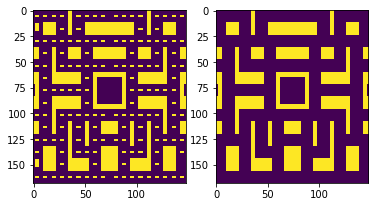

In [3]:
# MsPacman-ram-v0
env = gym.make('MsPacman-ram-v0')
env.reset();
screen_raw = env.env.ale.getScreen().reshape(210, 160)
screen_raw = screen_raw[2:170, 6:154]

# the free space has value 144
# walls and food have value 74
SPECIFIC_VALUE = 74
screen = (screen_raw == SPECIFIC_VALUE).astype(int)

food_kernel = np.array([[-1, -1, -1, -1, -1, -1],
                        [-1,  1,  1,  1,  1, -1],
                        [-1,  1,  1,  1,  1, -1],
                        [-1, -1, -1, -1, -1, -1]])

# Get the food positions
filter = screen2filter(screen, food_kernel)
food_coords = filter2coords(filter)
special_food_coords = np.array([[17, 4], [148, 4], [17, 143], [149, 143]])

walls = get_walls_matrix(screen, food_coords, special_food_coords)

np.save("saved_objects/food_walls_matrix.npy", screen)
np.save("saved_objects/walls_matrix.npy", walls)
np.save("saved_objects/food_coords.npy", food_coords)
np.save("saved_objects/special_food_coords.npy", special_food_coords)


plt.subplot(1, 2, 1)
plt.imshow(screen)

plt.subplot(1, 2, 2)
plt.imshow(walls)

plt.show()